In [1]:
%pip install opencv-python
%pip install pandas
%pip install numpy
%pip install matplotlib

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

In [3]:
# Load the image
image_path = "Test Images/image1.jpeg"
image = cv2.imread(image_path)

# Crop the image
x = 675
y = 300
w = 2500
h = 2400
cropped_image = image[y : y + h, x : x + w]

# Resize the image
resize_image = cv2.resize(cropped_image, (720, 720))
resize_image = cv2.cvtColor(resize_image, cv2.COLOR_BGR2RGB)

# Convert the image to HSV
hsv_image = cv2.cvtColor(resize_image, cv2.COLOR_RGB2HSV)

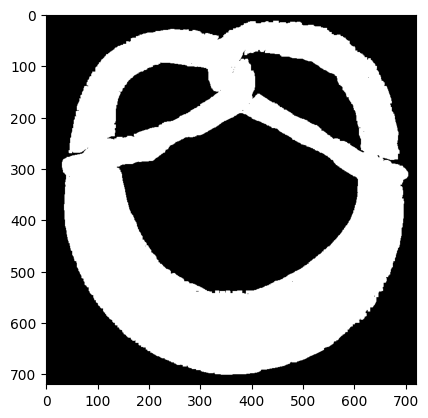

In [4]:
# Define the lower and upper bounds of the HSV range
h_min = 13
h_max = 25
s_min = 52
s_max = 111
v_min = 75
v_max = 209

# Create masks based on the HSV range
def create_mask(hsv_image):
    lower_bound = np.array([h_min, s_min, v_min])
    upper_bound = np.array([h_max, s_max, v_max])
    mask = cv2.inRange(hsv_image, lower_bound, upper_bound)

    kernel = np.ones((5, 5), np.uint8)
    
    # opening operation
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    
    return mask

mask = create_mask(hsv_image)
plt.imshow(mask, cmap="gray")
plt.show()

In [5]:
# Find contours
contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contour_image = cv2.drawContours(resize_image.copy(), contours, -1, (0, 255, 0), 5)

In [6]:
# Filter contours based on area
contours_area_image = resize_image.copy()
min_area = 10000
selected_contours = []

for c in contours:
    area = cv2.contourArea(c)
    if min_area <= area:
        selected_contours.append(c)

selected_contours.sort(key = cv2.contourArea, reverse = True)

In [7]:
A1, A2, A3 = None, None, None

for i, c in enumerate(selected_contours):
    x, y, w, h = cv2.boundingRect(c)
    x_mid = x + w // 2
    y_mid = y + h // 2

    _ = c[c[:, :, 1].argsort(axis=0)].reshape(-1, 2)

    if (i==0):
        print("Outline")
        A0 = ["A0", c, cv2.contourArea(c), (x_mid, y_mid), (x, y, w, h), (_[0], _[-1])]
    elif (x_mid < 360) and (y_mid < 360):
        print("Top left")
        A2 = ["A2", c, cv2.contourArea(c), (x_mid, y_mid), (x, y, w, h), (_[0], _[-1])]
    elif (x_mid > 360) and (y_mid < 360):
        print("Top right")
        A3 = ["A3", c, cv2.contourArea(c), (x_mid, y_mid), (x, y, w, h), (_[0], _[-1])]
    else:
        print("Bottom")
        A1 = ["A1", c, cv2.contourArea(c), (x_mid, y_mid), (x, y, w, h), (_[0], _[-1])]

required_contours = [A1, A2, A3]
for sc in required_contours:
    if sc is None:
        continue
    color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    cv2.drawContours(contours_area_image, [sc[1]], -1, color, 5)
    cv2.putText(
        contours_area_image, sc[0], sc[3], cv2.FONT_HERSHEY_SIMPLEX, 3, color, 5
    )

Outline
Bottom
Top right
Top left


In [8]:
def line_intersection(line1, line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
        return None

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return x, y


def find_contour_line_intersections(contours, line):
    intersections = []

    for contour in contours:
        for i in range(len(contour)):
            # Get two consecutive points of the contour
            p1 = tuple(contour[i][0])
            p2 = tuple(contour[(i + 1) % len(contour)][0])

            # Check intersection
            intersection = line_intersection(line, (p1, p2))
            if intersection:
                # Check if the intersection point is on the line segment
                x, y = intersection
                if (
                    min(p1[0], p2[0]) <= x <= max(p1[0], p2[0])
                    and min(p1[1], p2[1]) <= y <= max(p1[1], p2[1])
                    and min(line[0][0], line[1][0]) <= x <= max(line[0][0], line[1][0])
                    and min(line[0][1], line[1][1]) <= y <= max(line[0][1], line[1][1])
                ):
                    intersections.append(intersection)

    return intersections

In [9]:
lineImage = resize_image.copy()

cv2.line(
    lineImage,
    (A0[3][0], A0[4][1]),
    (A0[3][0], A0[4][1] + A0[4][3]),
    (255, 255, 255),
    5,
)  # h1

cv2.line(
    lineImage,
    A1[5][0],
    (A1[5][0][0],A0[5][0][1]),
    (255, 255, 0),
    5,
)  # h2


cv2.line(
    lineImage,
    A1[5][1],
    (A1[5][1][0],A0[5][1][1]),
    (0, 255, 0),
    5,
) # B1

B2 = find_contour_line_intersections(contours, (A2[3], (A0[4][0], A0[4][1])))
B3 = find_contour_line_intersections(contours, (A3[3], (A0[4][0] + A0[4][2], A0[4][1])))

cv2.line(
    lineImage,
    (int(B2[0][0]), int(B2[0][1])),
    (int(B2[1][0]), int(B2[1][1])),
    (0, 255, 0),
    5,
)  # B2

cv2.line(
    lineImage,
    (int(B3[0][0]), int(B3[0][1])),
    (int(B3[1][0]), int(B3[1][1])),
    (0, 255, 0),
    5,
)  # B3

array([[[ 75,  69,  66],
        [ 65,  59,  56],
        [102,  97,  94],
        ...,
        [118, 110, 109],
        [ 87,  79,  77],
        [ 25,  17,  15]],

       [[ 97,  92,  89],
        [ 89,  84,  81],
        [ 69,  64,  61],
        ...,
        [122, 114, 112],
        [ 65,  57,  55],
        [ 28,  20,  18]],

       [[142, 137, 134],
        [135, 130, 127],
        [112, 107, 104],
        ...,
        [ 45,  37,  35],
        [ 88,  80,  78],
        [ 85,  77,  75]],

       ...,

       [[118, 109, 102],
        [103,  94,  87],
        [ 78,  69,  62],
        ...,
        [ 86,  77,  71],
        [ 90,  81,  75],
        [ 92,  83,  76]],

       [[103,  94,  87],
        [130, 121, 114],
        [120, 111, 104],
        ...,
        [ 87,  78,  71],
        [ 90,  81,  74],
        [ 96,  87,  80]],

       [[123, 114, 107],
        [148, 139, 132],
        [208, 199, 193],
        ...,
        [ 85,  76,  69],
        [ 90,  81,  74],
        [ 94,  85,  78]]

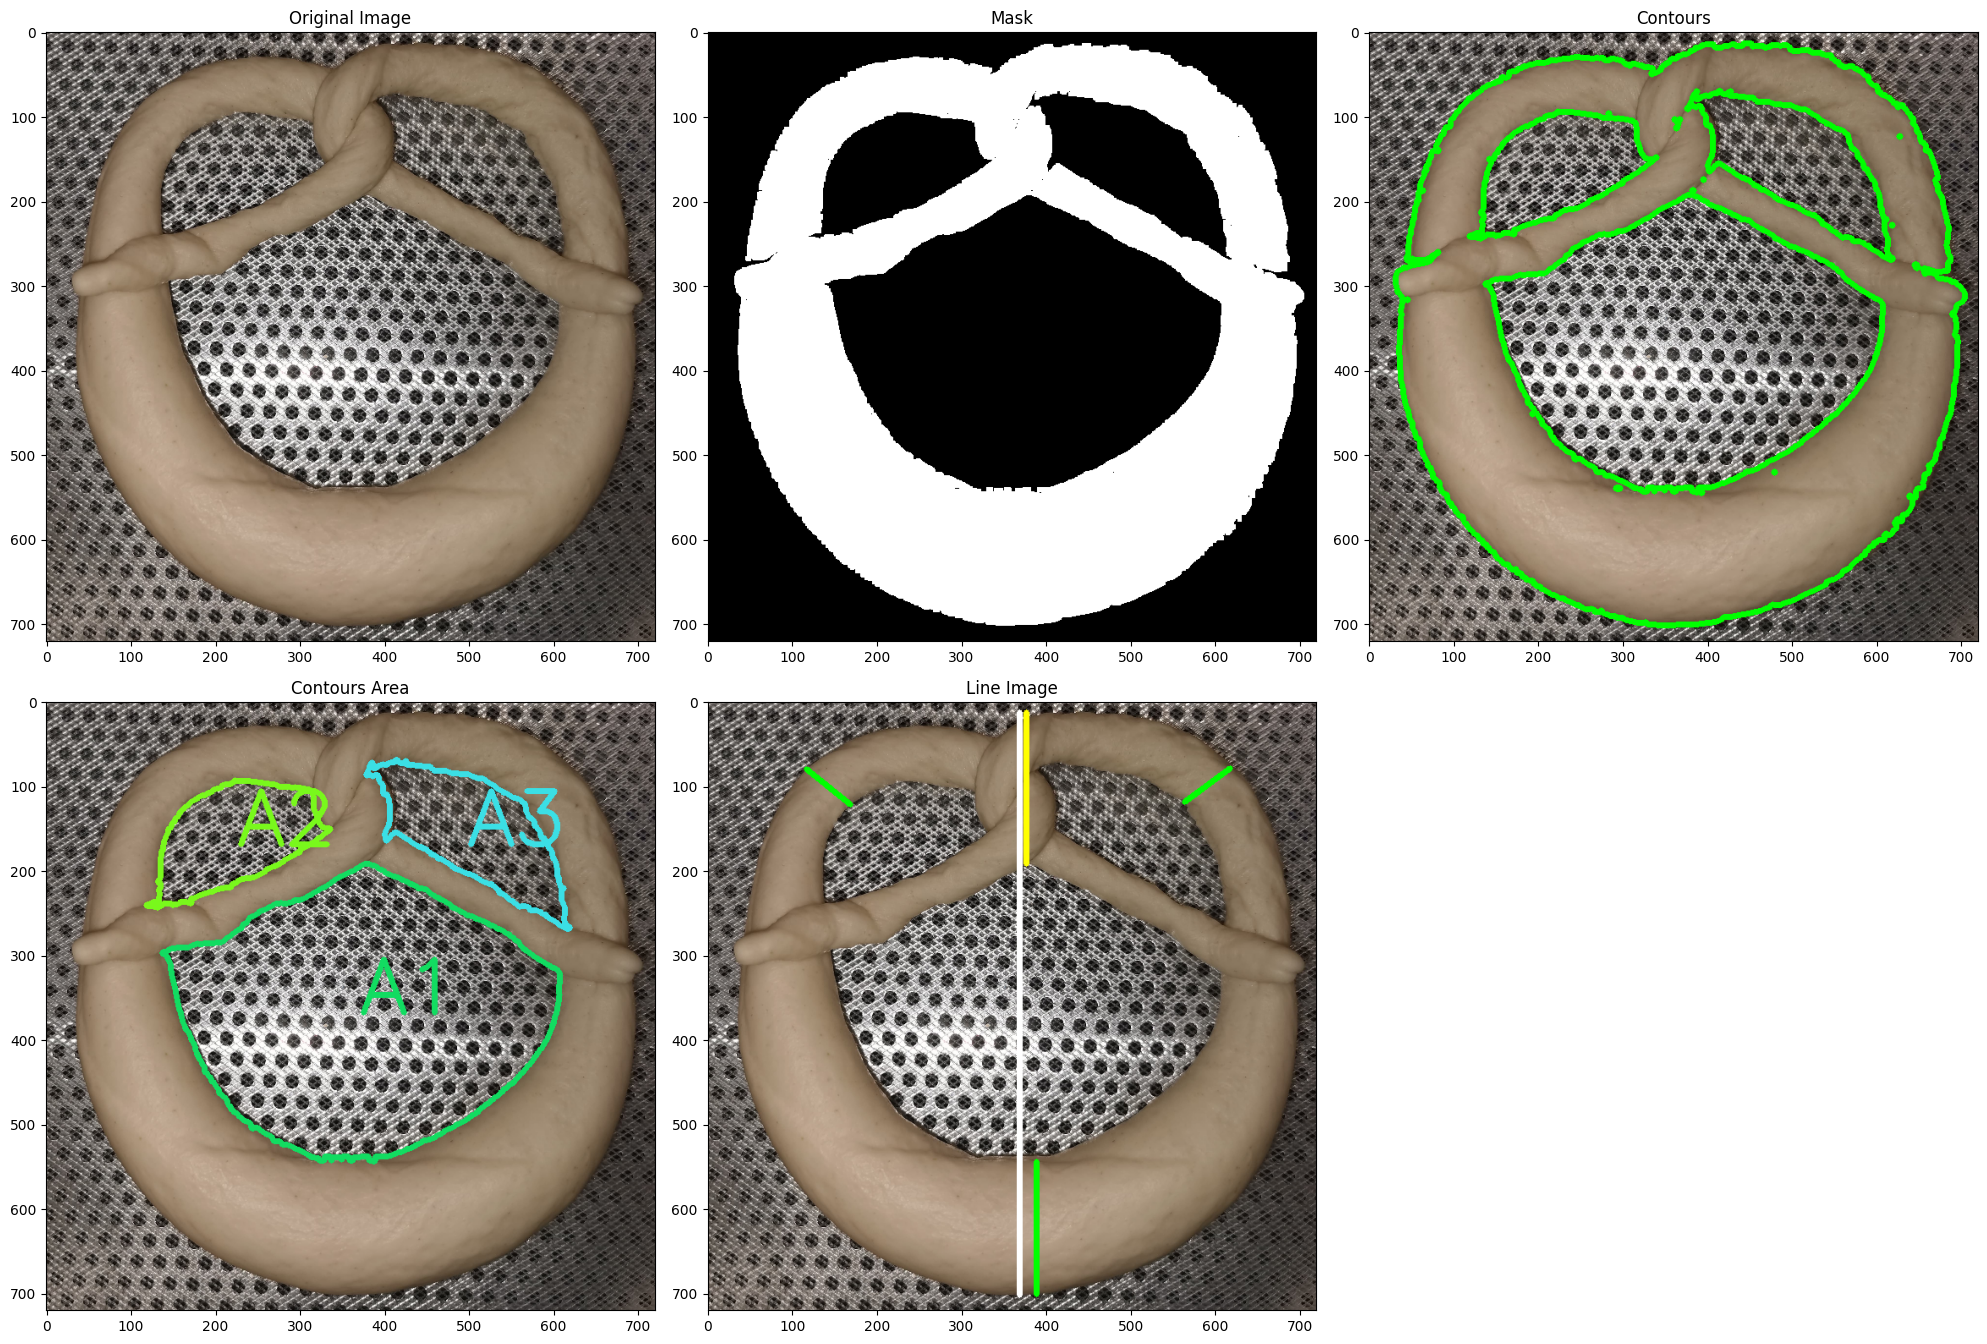

In [17]:
# Increase figure size
plt.figure(figsize=(20, 20))  # Adjust the figsize to fit your needs

row = 3
col = 3

# # Adjust subplot parameters to give more space
# plt.subplots_adjust(wspace=0.4, hspace=0.6)

# Subplot 1
plt.subplot(row, col, 1)
plt.title("Original Image")
plt.imshow(resize_image)

# Subplot 2
plt.subplot(row, col, 2)
plt.title("Mask")
plt.imshow(mask, cmap="gray")

# Subplot 3
plt.subplot(row, col, 3)
plt.title("Contours")
plt.imshow(contour_image, cmap="gray")

# Subplot 4
plt.subplot(row, col, 4)
plt.title("Contours Area")
plt.imshow(contours_area_image, cmap="gray")

# Subplot 5
plt.subplot(row, col, 5)
plt.title("Line Image")
plt.imshow(lineImage, cmap="gray")

# Adjust layout to ensure there's no overlap
plt.tight_layout()

plt.show()

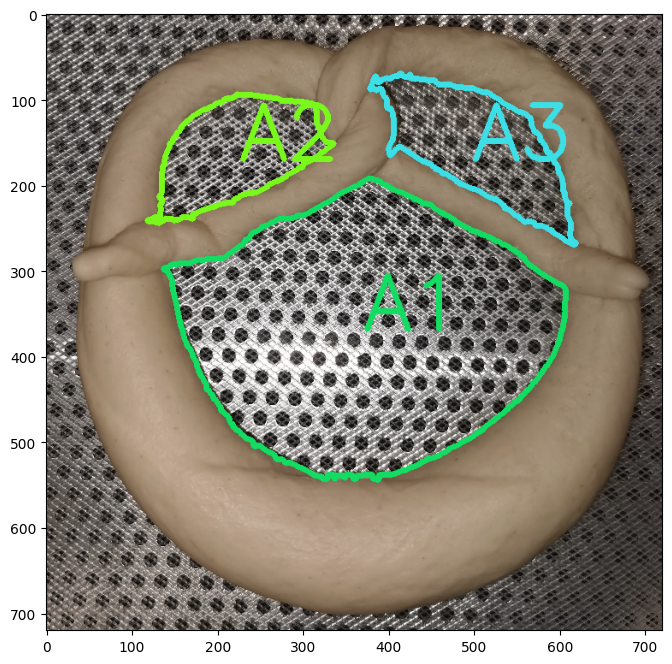

In [11]:
plt.figure(figsize=(12, 8))  # Adjust the figsize to fit your needs
plt.imshow(contours_area_image, cmap="gray")

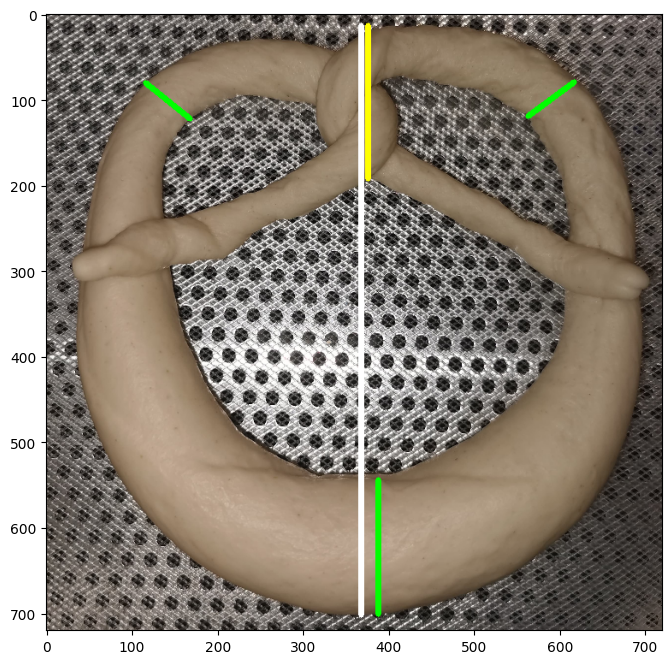

In [12]:
plt.figure(figsize=(12, 8))  # Adjust the figsize to fit your needs
plt.imshow(lineImage, cmap="gray")